## Config

In [1]:
from platform import python_version
print("VERSION: ", python_version()) # expect 3.7.0

VERSION:  3.7.0


In [2]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
from spacy.vocab import Vocab
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import random
import itertools
from itertools import chain
from PyDictionary import PyDictionary
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess

In [3]:
# dirty spaCy error workaround:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [4]:
# define the spaCy lib for vocab and vectors
nlp = spacy.load('en')
nlp_larg = spacy.load('en_core_web_lg')

In [5]:
# could use nltk, but these are pretty easy to work with
dictionary=PyDictionary()

In [6]:
# Data location
forms_dir = '../input_data/all_forms'

## Semantic Clues
These are the verbs that we believe indicate the prescence of a statement of 'allowable action.'

Taken from: 

```
“I found synonyms for ‘permission’ on the new Thesaurus.com!,”
www.thesaurus.com. [Online]. Available: https://www.thesaurus.com/browse/permission. 
[Accessed: 19-Feb-2019].
```

In [7]:
semantic_bases = ["permission", 
                "authorization", 
                "authorize",
                "consent",
                "assent",
                "permit",
                "approve",
                "grant",
                "allow",
                "certify"]

## Print Base Definitions

In [8]:
for base in semantic_bases:
    print (base)
    
    for (POS,Def) in dictionary.meaning(base).items():
        print("   ", POS, ":", Def, '\n')

permission


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Noun : ['approval to do something', 'the act of giving a formal (usually written'] 

authorization
    Noun : ['a document giving an official instruction or command', 'the power or right to give orders or make decisions', 'official permission or approval', 'the act of conferring legality or sanction or formal warrant'] 

authorize
    Verb : ['grant authorization or clearance for', 'give or delegate power or authority to'] 

consent
    Noun : ['permission to do something'] 

    Verb : ['give an affirmative reply to; respond favorably to'] 

assent
    Noun : ['agreement with a statement or proposal to do something'] 

    Verb : ['to agree or express agreement'] 

permit
    Noun : ['a legal document giving official permission to do something', 'the act of giving a formal (usually written', 'large game fish; found in waters of the West Indies'] 

    Verb : ['consent to, give permission', 'make it possible through a specific action or lack of action for something to happen', 'all

## Add Synonyms
Use WordNet to gather synonyms of the semantic clues.

In [9]:
def addWordNetSynsets(word_list):
    """  add synsets to new list """
    updated_list = []
    
    for word in word_list:
        updated_list.append(word)
        
        v_synonyms = wordnet.synsets(word, "v")
        v_synonyms = set(chain.from_iterable([word.lemma_names() for word in v_synonyms]))
        
        [updated_list.append(x) for x in v_synonyms if x not in updated_list]
        
    print('Done!')
    return set(updated_list)

In [10]:
extended_semantic_clues = addWordNetSynsets(semantic_bases)

Done!


In [11]:
# expect 50
print('unique elements in extended semantic clues:', 
      len(extended_semantic_clues), '\n')

unique elements in extended semantic clues: 50 



In [12]:
for clue in extended_semantic_clues:
    print(clue)

permit
allow
award
deed_over
provide
clear
permission
demonstrate
indorse
cede
manifest
let
sanction
grant
empower
countenance
yield
consent
attest
tolerate
authorization
concede
authorise
allot
acquiesce
evidence
licence
license
go_for
certify
assent
authorize
give
O.K.
appropriate
accede
pass
take_into_account
reserve
accept
okay
leave
allow_for
endorse
accord
give_up
set_aside
earmark
admit
approve


## Check Clue Similarities
Turns out not to be very helpful

In [13]:
clue_similarity_matrix = pd.DataFrame(index=extended_semantic_clues, 
                                      columns=extended_semantic_clues)

for index, row in clue_similarity_matrix.iterrows():
    for base in extended_semantic_clues:
        base_syn = wordnet.synsets(base)
        index_syn = wordnet.synsets(index)
        sim = wordnet.wup_similarity(index_syn[0], base_syn[0])
        
        if sim != None:
            row[base] = wordnet.wup_similarity(index_syn[0], base_syn[0])
        else:
            row[base] = 0.0
        
clue_similarity_matrix = clue_similarity_matrix.astype(float)

Unfortunately, this doesn't help us automate 'culling' of terms we don't really like.

In [14]:
clue_similarity_matrix.describe(include = 'all').transpose().sort_values('mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
sanction,50.0,0.302470,0.218631,0.133333,0.157051,0.211111,0.307692,1.0
permission,50.0,0.299393,0.210655,0.133333,0.157051,0.211111,0.307692,1.0
okay,50.0,0.286088,0.220545,0.125000,0.145604,0.190909,0.285714,1.0
O.K.,50.0,0.286088,0.220545,0.125000,0.145604,0.190909,0.285714,1.0
consent,50.0,0.280374,0.204810,0.125000,0.145604,0.190909,0.285714,1.0
permit,50.0,0.270695,0.218933,0.117647,0.135714,0.174242,0.266667,1.0
license,50.0,0.270695,0.218933,0.117647,0.135714,0.174242,0.266667,1.0
manifest,50.0,0.268195,0.211005,0.117647,0.135714,0.174242,0.266667,1.0
authorization,50.0,0.268195,0.211005,0.117647,0.135714,0.174242,0.266667,1.0
countenance,50.0,0.259503,0.144245,0.133333,0.157051,0.211111,0.307692,1.0


In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

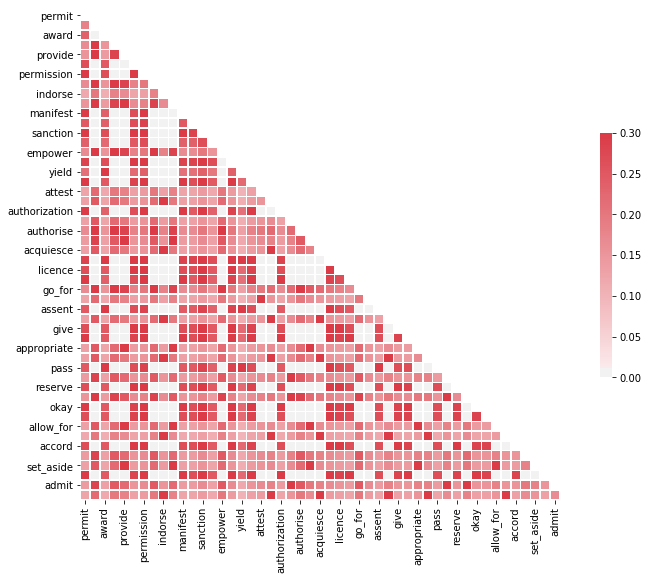

In [16]:
# Generate a mask for the upper triangle
mask = np.zeros_like(clue_similarity_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(clue_similarity_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Remove Inapproriate Clues

Here we define a list of terms we will remove from the semantic clues.

In [17]:
"""
Define a list to remove selected words from the semantic clues. 
WordNet has it's weaknesses.
"""
poorly_fitting_semantic_clues = {
     'manifest',
     'yield',
     'demonstrate',
     'endorse',
     'take_into_account',
     'allow_for',
     'set_aside',
     'clear',
     'acquiesce',
     'indorse',
     'go_for',
     'earmark',
     'license',
     'reserve',
     'pass',
     'tolerate',
     'O.K.',
     'deed_over',
     'award',
     'evidence',
     'appropriate',
     'leave',
     'give_up',
     'empower',
     'okay',
     'countenance'
}

In [18]:
permission_extended = list(poorly_fitting_semantic_clues ^ extended_semantic_clues)

In [19]:
print('num terms after culling: ', len(permission_extended), '\n')

for term in permission_extended:
    print(term)

num terms after culling:  24 

permit
allow
provide
permission
cede
let
sanction
grant
consent
attest
authorization
concede
authorise
allot
licence
certify
assent
authorize
give
accede
accept
accord
admit
approve


## Check definitions

In [20]:
for clue in permission_extended:
    print(clue)
    
    for (POS,Def) in dictionary.meaning(clue).items():
        print("   ", POS, ":", Def, '\n')

permit


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Noun : ['a legal document giving official permission to do something', 'the act of giving a formal (usually written', 'large game fish; found in waters of the West Indies'] 

    Verb : ['consent to, give permission', 'make it possible through a specific action or lack of action for something to happen', 'allow the presence of or allow (an activity'] 

allow


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Verb : ['make it possible through a specific action or lack of action for something to happen', 'consent to, give permission', 'let have', 'give or assign a resource to a particular person or cause', 'make a possibility or provide opportunity for; permit to be attainable or cause to remain', 'allow or plan for a certain possibility; concede the truth or validity of something', 'afford possibility', 'allow the other (baseball', 'grant as a discount or in exchange', 'allow the presence of or allow (an activity'] 

provide


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Verb : ['give something useful or necessary to', 'give what is desired or needed, especially support, food or sustenance', 'determine (what is to happen in certain contingencies', 'mount or put up', 'make a possibility or provide opportunity for; permit to be attainable or cause to remain', 'supply means of subsistence; earn a living', 'take measures in preparation for'] 

permission


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Noun : ['approval to do something', 'the act of giving a formal (usually written'] 

cede


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Verb : ['give over; surrender or relinquish to the physical control of another', 'relinquish possession or control over'] 

let


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Noun : ['a brutal terrorist group active in Kashmir; fights against India with the goal of restoring Islamic rule of India', "a serve that strikes the net before falling into the receiver's court; the ball must be served again"] 

    Verb : ['make it possible through a specific action or lack of action for something to happen', 'actively cause something to happen', 'consent to, give permission', 'cause to move; cause to be in a certain position or condition', 'leave unchanged', 'grant use or occupation of under a term of contract'] 

sanction


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Noun : ['formal and explicit approval', "a mechanism of social control for enforcing a society's standards", 'official permission or approval', 'the act of final authorization'] 

    Verb : ['give sanction to', 'give authority or permission to', 'give religious sanction to, such as through on oath'] 

grant


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Noun : ['any monetary aid', 'the act of providing a subsidy', 'Scottish painter; cousin of Lytton Strachey and member of the Bloomsbury Group (1885-1978', 'United States actor (born in England', '1904-1986', '18th President of the United States; commander of the Union armies in the American Civil War (1822-1885', 'a contract granting the right to operate a subsidiary business', 'a right or privilege that has been granted'] 

    Verb : ['let have', 'give as judged due or on the basis of merit', 'be willing to concede', 'allow to have', 'bestow, especially officially', 'give over; surrender or relinquish to the physical control of another', 'transfer by deed'] 

consent


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Noun : ['permission to do something'] 

    Verb : ['give an affirmative reply to; respond favorably to'] 

attest


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Verb : ["provide evidence for; stand as proof of; show by one's behavior, attitude, or external attributes", 'authenticate, affirm to be true, genuine, or correct, as in an official capacity', 'give testimony in a court of law', 'establish or verify the usage of'] 

authorization


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Noun : ['a document giving an official instruction or command', 'the power or right to give orders or make decisions', 'official permission or approval', 'the act of conferring legality or sanction or formal warrant'] 

concede


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Verb : ['admit (to a wrongdoing', 'be willing to concede', 'give over; surrender or relinquish to the physical control of another', 'acknowledge defeat'] 

authorise


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Verb : ['give or delegate power or authority to', 'grant authorization or clearance for'] 

allot


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Verb : ['give out', 'allow to have', 'administer or bestow, as in small portions'] 

licence


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Noun : ['excessive freedom; lack of due restraint', 'freedom to deviate deliberately from normally applicable rules or practices (especially in behavior or speech', 'a legal document giving official permission to do something'] 

    Verb : ['authorize officially'] 

certify


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Verb : ["provide evidence for; stand as proof of; show by one's behavior, attitude, or external attributes", 'guarantee payment on; of checks', 'authorize officially', 'guarantee as meeting a certain standard', 'declare legally insane'] 

assent


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Noun : ['agreement with a statement or proposal to do something'] 

    Verb : ['to agree or express agreement'] 

authorize


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Verb : ['grant authorization or clearance for', 'give or delegate power or authority to'] 

give


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Noun : ['the elasticity of something that can be stretched and returns to its original length'] 

    Verb : ['cause to have, in the abstract sense or physical sense', 'be the cause or source of', 'transfer possession of something concrete or abstract to somebody', 'convey or reveal information', 'convey, as of a compliment, regards, attention, etc.; bestow', 'organize or be responsible for', 'convey or communicate; of a smile, a look, a physical gesture', 'give as a present; make a gift of', 'cause to happen or be responsible for', 'dedicate', 'give or supply', 'transmit (knowledge or skills', 'bring about', 'leave with; give temporarily', 'emit or utter', 'endure the loss of', 'place into the hands or custody of', 'give entirely to a specific person, activity, or cause', 'give (as medicine', 'give or convey physically', 'bestow', 'bestow, especially officially', 'move in order to make room    f   o   r       s   o   m   e   o   n   e       f   o   r       s   o   m   e   t   h   

/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Verb : ["yield to another's wish or opinion", 'take on duties or office', 'to agree or express agreement'] 

accept


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Verb : ['consider or hold as true', 'receive willingly something given or offered', 'give an affirmative reply to; respond favorably to', 'react favorably to; consider right and proper', 'admit into a group or community', "take on as one's own the expenses or debts of another person", 'tolerate or accommodate oneself to', 'be designed to hold or take', 'receive (a report', 'make use of or accept for some purpose', 'be sexually responsive to, used of a female domesticated mammal'] 

accord


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Noun : ["harmony of people's opinions or actions or characters", 'concurrence of opinion', 'a written agreement between two states or sovereigns', 'sympathetic compatibility'] 

    Verb : ['go together', 'allow to have'] 

admit


/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


    Verb : ['declare to be true or admit the existence or reality or truth of', 'allow to enter; grant entry to', 'allow participation in or the right to be part of; permit to exercise the rights, functions, and responsibilities of', 'admit into a group or community', 'afford possibility', 'give access or entrance to', 'have room for; hold without crowding', 'serve as a means of entrance'] 

approve
    Verb : ['give sanction to', 'judge to be right or commendable; think well of'] 



/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


## build consent form data structure
get dataframe from each consent form on file

In [21]:
def getData(directory):
    """ returns a dataframe with cleaned filenames, full paths,
    and unprocessed text """
    
    new_rows = []
    
    fileID = 0
    
    # iterate through directory
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            
            fileID += 1
            filepath = subdir + os.sep + file
            
            if filepath.endswith('.txt'):
                
                # perform string operations on each file
                with open(filepath, 'r') as myfile:
                    data = myfile.read().replace('\n', ' ')       
                
                new_rows.append(
                    {
                        'id': fileID,
                        'name':str(file),
                        'path':filepath,
                        'rawText':data
                    }
                )
    
    return pd.DataFrame(new_rows)

In [22]:
"""
NOTE: running this cell will re-load the data in the dataframe from the dir.
"""
# run the function and store to variable 
df = getData(forms_dir)

# set the index as the id, for future access
df = df.set_index('id')
df.head()

,name,path,rawText
id,,,
1,TAMU - HRPP Informed consent.txt,../input_data/all_forms/TAMU - HRPP Informed c...,﻿NOT INTENDED FOR USE WITHOUT TAMU/BCD IRB APP...
2,Potomac Primary Care_flu-consent-form.txt,../input_data/all_forms/Potomac Primary Care_f...,PATIENT CONSENT FORM FOR SEASONAL INFLUENZA VA...
3,OSU_Scheduled_Delivery_Consent.txt,../input_data/all_forms/OSU_Scheduled_Delivery...,SCHEDULED DELIVERY: Today’s Date: Da...
4,consent_biorepository_12-19-14.txt,../input_data/all_forms/consent_biorepository_...,﻿ Informed Consent Form and HIPAA Authorizatio...
5,Cambridge_Consent_endodontics2.txt,../input_data/all_forms/Cambridge_Consent_endo...,INFORMAT IONAL USE ONLY CONSENT FOR ENDODONTI...


## Random sampling to speed up development
This will be removed when we want to process the whole corpus.

In [23]:
# comment out to run on whole document collection
n_samples = 35
df = df.sample(n=n_samples)

## Add Clean Text To DataFrame

In [24]:
def minimalTextCleaning(row, field):
    """ perform minimal text processing on raw data to new field """
    
    cleaned_text = str(row[field]).lower() # lowercase
    cleaned_text = re.sub(' +', ' ', cleaned_text) # strip redundant whitespace
    cleaned_text = cleaned_text.replace("_", "") # we don't want signature lines
    return cleaned_text

df['minimalCleaning'] = df.apply(lambda row:minimalTextCleaning(row, 'rawText'),axis=1)

In [25]:
df.head()

,name,path,rawText,minimalCleaning
id,,,,
53,ICS Short Form ENG.txt,../input_data/all_forms/ICS Short Form ENG.txt,Consent to Participate in Research You are bei...,consent to participate in research you are bei...
219,PMBB Informed Consent (1).txt,../input_data/all_forms/PMBB Informed Consent ...,\t PENN Medicine BioBank UNIVERSITY ...,\t penn medicine biobank university of penns...
383,Believe_Midwifery_PROM-Informed-Consent-Form.txt,../input_data/all_forms/Believe_Midwifery_PROM...,behave WFORMED CHOICE for PRELABOR RUPTURE OF ...,behave wformed choice for prelabor rupture of ...
337,DECK DENTISTRY_Consent for Endodontic Treatmen...,../input_data/all_forms/DECK DENTISTRY_Consent...,DECK DENTISTRY | Consent for Endodontic Treatm...,deck dentistry | consent for endodontic treatm...
283,Southern Regional Medical Center_ConsentOrRefu...,../input_data/all_forms/Southern Regional Medi...,Consent or Refusal for Blood/Blood Products 2C...,consent or refusal for blood/blood products 2c...


In [26]:
df['minimalCleaning'].iloc[0]

'consent to participate in research you are being asked to participate in a research study. before you agree, the investigator must tell you about (i) the purposes, procedures, and duration of the research; (ii) any procedures which are experimental; (iii) any reasonably foreseeable risks, discomforts, and benefits of the research; (iv) any potentially beneficial alternative procedures or treatments; and (v) how confidentiality will be maintained. where applicable, the investigator must also tell you about (i) any available compensation or medical treatment if injury occurs; (ii) the possibility of unforeseeable risks; (iii) circumstances when the investigator may halt your participation; (iv) any added costs to you; (v) what happens if you decide to stop participating; (vi) when you will be told about new findings which may affect your willingness to participate; and (vii) how many people will be in the study. if you agree to participate, you must be given a signed copy of this docume

## Convert Raw Text to Spacy Object
Once for the raw text, once for the cleaned text.

In [27]:
def getDocObjects(row, field):
    " return spacy doc object"
    doc = nlp_larg(str(row[field]).lower())
    return doc

In [28]:
convertFrom = 'rawText'
convertTo = convertFrom + 'DOC'

df[convertTo] = df.apply(lambda row:getDocObjects(row, convertFrom),axis=1)

In [29]:
convertFrom = 'minimalCleaning'
convertTo = convertFrom + 'DOC'

df[convertTo] = df.apply(lambda row:getDocObjects(row, convertFrom),axis=1)

In [30]:
df.head()

,name,path,rawText,minimalCleaning,rawTextDOC,minimalCleaningDOC
id,,,,,,
53,ICS Short Form ENG.txt,../input_data/all_forms/ICS Short Form ENG.txt,Consent to Participate in Research You are bei...,consent to participate in research you are bei...,"(consent, to, participate, in, research, you, ...","(consent, to, participate, in, research, you, ..."
219,PMBB Informed Consent (1).txt,../input_data/all_forms/PMBB Informed Consent ...,\t PENN Medicine BioBank UNIVERSITY ...,\t penn medicine biobank university of penns...,"(\t , penn, medicine, biobank, , uni...","(\t , penn, medicine, biobank, university, o..."
383,Believe_Midwifery_PROM-Informed-Consent-Form.txt,../input_data/all_forms/Believe_Midwifery_PROM...,behave WFORMED CHOICE for PRELABOR RUPTURE OF ...,behave wformed choice for prelabor rupture of ...,"(behave, wformed, choice, for, prelabor, ruptu...","(behave, wformed, choice, for, prelabor, ruptu..."
337,DECK DENTISTRY_Consent for Endodontic Treatmen...,../input_data/all_forms/DECK DENTISTRY_Consent...,DECK DENTISTRY | Consent for Endodontic Treatm...,deck dentistry | consent for endodontic treatm...,"(deck, dentistry, |, consent, for, endodontic,...","(deck, dentistry, |, consent, for, endodontic,..."
283,Southern Regional Medical Center_ConsentOrRefu...,../input_data/all_forms/Southern Regional Medi...,Consent or Refusal for Blood/Blood Products 2C...,consent or refusal for blood/blood products 2c...,"(consent, or, refusal, for, blood, /, blood, p...","(consent, or, refusal, for, blood, /, blood, p..."


## Extract all Sentences
As spaCy doc objects (token.span)

In [31]:
def getSentenceList(row, field):
    """ return list of sentences from doc object; each item will be token span """
    return list(row[field].sents)

In [32]:
getFrom = 'rawTextDOC'
convertTo = getFrom + '_sentenceList'

df[convertTo] = df.apply(lambda row:getSentenceList(row, getFrom),axis=1)

In [33]:
getFrom = 'minimalCleaningDOC'
convertTo = getFrom + '_sentenceList'

df[convertTo] = df.apply(lambda row:getSentenceList(row, getFrom),axis=1)

In [34]:
df.head()

,name,path,rawText,minimalCleaning,rawTextDOC,minimalCleaningDOC,rawTextDOC_sentenceList,minimalCleaningDOC_sentenceList
id,,,,,,,,
53,ICS Short Form ENG.txt,../input_data/all_forms/ICS Short Form ENG.txt,Consent to Participate in Research You are bei...,consent to participate in research you are bei...,"(consent, to, participate, in, research, you, ...","(consent, to, participate, in, research, you, ...","[(consent, to, participate, in, research), (yo...","[(consent, to, participate, in, research), (yo..."
219,PMBB Informed Consent (1).txt,../input_data/all_forms/PMBB Informed Consent ...,\t PENN Medicine BioBank UNIVERSITY ...,\t penn medicine biobank university of penns...,"(\t , penn, medicine, biobank, , uni...","(\t , penn, medicine, biobank, university, o...","[(\t , penn, medicine, biobank, , un...","[(\t , penn, medicine, biobank, university, ..."
383,Believe_Midwifery_PROM-Informed-Consent-Form.txt,../input_data/all_forms/Believe_Midwifery_PROM...,behave WFORMED CHOICE for PRELABOR RUPTURE OF ...,behave wformed choice for prelabor rupture of ...,"(behave, wformed, choice, for, prelabor, ruptu...","(behave, wformed, choice, for, prelabor, ruptu...","[(behave, wformed, choice, for, prelabor, rupt...","[(behave, wformed, choice, for, prelabor, rupt..."
337,DECK DENTISTRY_Consent for Endodontic Treatmen...,../input_data/all_forms/DECK DENTISTRY_Consent...,DECK DENTISTRY | Consent for Endodontic Treatm...,deck dentistry | consent for endodontic treatm...,"(deck, dentistry, |, consent, for, endodontic,...","(deck, dentistry, |, consent, for, endodontic,...","[(deck, dentistry, |, consent, for, endodontic...","[(deck, dentistry, |, consent, for, endodontic..."
283,Southern Regional Medical Center_ConsentOrRefu...,../input_data/all_forms/Southern Regional Medi...,Consent or Refusal for Blood/Blood Products 2C...,consent or refusal for blood/blood products 2c...,"(consent, or, refusal, for, blood, /, blood, p...","(consent, or, refusal, for, blood, /, blood, p...","[(consent, or, refusal, for, blood, /, blood, ...","[(consent, or, refusal, for, blood, /, blood, ..."


## Empirical Evidence for Using Minimial Cleaning

In [35]:
for list_of_setences in df['rawTextDOC_sentenceList'].head(1):
    for sentence in list_of_setences[:10]:
        print(sentence, '\n')

consent to participate in research 

you are being asked to participate in a research study. 

before you agree, the investigator must tell you about (i) the purposes, procedures, and duration of the research; (ii) any procedures which are experimental; (iii) any reasonably foreseeable risks, discomforts, and benefits of the research; (iv) any potentially beneficial alternative procedures or treatments; and (v) how confidentiality will be maintained. 

where applicable, the investigator must also tell you about (i) any available compensation or medical treatment if injury occurs; (ii) the possibility of unforeseeable risks; (iii) circumstances when the investigator may halt your participation; (iv) any added costs to you; (v) what happens if you decide to stop participating; (vi) when you will be told about new findings which may affect your willingness to participate; and (vii) how many people will be in the study. 

if you agree to participate, you must be given a signed copy of this

In [36]:
for list_of_setences in df['minimalCleaningDOC_sentenceList'].head(1):
    for sentence in list_of_setences[:10]:
        print(sentence, '\n')

consent to participate in research 

you are being asked to participate in a research study. 

before you agree, the investigator must tell you about (i) the purposes, procedures, and duration of the research; (ii) any procedures which are experimental; (iii) any reasonably foreseeable risks, discomforts, and benefits of the research; (iv) any potentially beneficial alternative procedures or treatments; and (v) how confidentiality will be maintained. 

where applicable, the investigator must also tell you about (i) any available compensation or medical treatment if injury occurs; (ii) the possibility of unforeseeable risks; (iii) circumstances when the investigator may halt your participation; (iv) any added costs to you; (v) what happens if you decide to stop participating; (vi) when you will be told about new findings which may affect your willingness to participate; and (vii) how many people will be in the study. 

if you agree to participate, you must be given a signed copy of this

In [37]:
# """
# Currently, this is an unused, but potentially helpful function.
# """

# def getWordListasString(row):
#     """ return a list of words, including duplicates.
#     NOTE: light cleaning on ingestion """
#     wordList = [] 
    
#     for word in row['rawText'].split():
#         word = re.sub("[^a-zA-Z]+", " ", word).strip().lower()
#         if not word == "":
#             wordList.append(word)
            
#     return " ".join(wordList)

## Strip short sentences

In [38]:
def removeShortSentences(row, field, length_threshold):
    """  remove extremely short sentences, as they are likely not helpful """
    
    stripped_sent = []
    
    for sentence in row[field]:
        if len(sentence.text) >= length_threshold:
            stripped_sent.append(sentence)
            
    return stripped_sent

In [42]:
getFrom = 'rawTextDOC_sentenceList'
convertTo = getFrom + '_stripped'
threshold = 5 # inlcudes whitespace

df[convertTo] = df.apply(lambda row:removeShortSentences(row, getFrom, threshold),axis=1)

In [39]:
getFrom = 'minimalCleaningDOC_sentenceList'
convertTo = getFrom + '_stripped'
threshold = 5 # inlcudes whitespace

df[convertTo] = df.apply(lambda row:removeShortSentences(row, getFrom, threshold),axis=1)

In [43]:
df.head()

,name,path,rawText,minimalCleaning,rawTextDOC,minimalCleaningDOC,rawTextDOC_sentenceList,minimalCleaningDOC_sentenceList,minimalCleaningDOC_sentenceList_stripped,rawTextDOC_sentenceList_stripped
id,,,,,,,,,,
53,ICS Short Form ENG.txt,../input_data/all_forms/ICS Short Form ENG.txt,Consent to Participate in Research You are bei...,consent to participate in research you are bei...,"(consent, to, participate, in, research, you, ...","(consent, to, participate, in, research, you, ...","[(consent, to, participate, in, research), (yo...","[(consent, to, participate, in, research), (yo...","[(consent, to, participate, in, research), (yo...","[(consent, to, participate, in, research), (yo..."
219,PMBB Informed Consent (1).txt,../input_data/all_forms/PMBB Informed Consent ...,\t PENN Medicine BioBank UNIVERSITY ...,\t penn medicine biobank university of penns...,"(\t , penn, medicine, biobank, , uni...","(\t , penn, medicine, biobank, university, o...","[(\t , penn, medicine, biobank, , un...","[(\t , penn, medicine, biobank, university, ...","[(\t , penn, medicine, biobank, university, ...","[(\t , penn, medicine, biobank, , un..."
383,Believe_Midwifery_PROM-Informed-Consent-Form.txt,../input_data/all_forms/Believe_Midwifery_PROM...,behave WFORMED CHOICE for PRELABOR RUPTURE OF ...,behave wformed choice for prelabor rupture of ...,"(behave, wformed, choice, for, prelabor, ruptu...","(behave, wformed, choice, for, prelabor, ruptu...","[(behave, wformed, choice, for, prelabor, rupt...","[(behave, wformed, choice, for, prelabor, rupt...","[(behave, wformed, choice, for, prelabor, rupt...","[(behave, wformed, choice, for, prelabor, rupt..."
337,DECK DENTISTRY_Consent for Endodontic Treatmen...,../input_data/all_forms/DECK DENTISTRY_Consent...,DECK DENTISTRY | Consent for Endodontic Treatm...,deck dentistry | consent for endodontic treatm...,"(deck, dentistry, |, consent, for, endodontic,...","(deck, dentistry, |, consent, for, endodontic,...","[(deck, dentistry, |, consent, for, endodontic...","[(deck, dentistry, |, consent, for, endodontic...","[(deck, dentistry, |, consent, for, endodontic...","[(deck, dentistry, |, consent, for, endodontic..."
283,Southern Regional Medical Center_ConsentOrRefu...,../input_data/all_forms/Southern Regional Medi...,Consent or Refusal for Blood/Blood Products 2C...,consent or refusal for blood/blood products 2c...,"(consent, or, refusal, for, blood, /, blood, p...","(consent, or, refusal, for, blood, /, blood, p...","[(consent, or, refusal, for, blood, /, blood, ...","[(consent, or, refusal, for, blood, /, blood, ...","[(consent, or, refusal, for, blood, /, blood, ...","[(consent, or, refusal, for, blood, /, blood, ..."


## Check Removal of Sents
Here we check to see how many sentences were removed using thresholding.

In [44]:
for index, row in df.head(5).iterrows():
    print(index, 'all sents: ', len(row['rawTextDOC_sentenceList']))
    print(index, 'stripped sents: ', len(row['rawTextDOC_sentenceList_stripped']))
    print()

53 all sents:  173
53 stripped sents:  18

219 all sents:  147
219 stripped sents:  137

383 all sents:  152
383 stripped sents:  149

337 all sents:  444
337 stripped sents:  23

283 all sents:  294
283 stripped sents:  50



In [45]:
for index, row in df.head(5).iterrows():
    print(index, 'all sents: ', len(row['minimalCleaningDOC_sentenceList']))
    print(index, 'stripped sents: ', len(row['minimalCleaningDOC_sentenceList_stripped']))
    print()

53 all sents:  10
53 stripped sents:  10

219 all sents:  139
219 stripped sents:  126

383 all sents:  149
383 stripped sents:  146

337 all sents:  15
337 stripped sents:  15

283 all sents:  46
283 stripped sents:  45



## preliminary permisison sentence extraction
Look for sentences that has ANY word from the 'clues' list.

### TODO: Do we want pairs, or triple-sentences?

In [46]:
def getPossiblePermissions(row, permissions_list, getCandidates_from):
    """ return list of sentences containing the 
    permissions words """
    
    candidates = []
    
    # iterate through a list of sentences
    for sent in row[getCandidates_from]:
        
        # iterate through each clue
        for clue in permissions_list:     
            
            # check if sting contains any clues (need to match case)
            if sent.text.__contains__(clue):
                """ NOTE: right not if ANY clue is found, this is enough """
                
                candidates.append(sent)
                break
    
    return candidates

In [50]:
getCandidates_from = 'minimalCleaningDOC_sentenceList_stripped'
to = 'CANDIDATES_' + getCandidates_from

df[to] = df.apply(lambda row:getPossiblePermissions(row, permission_extended, getCandidates_from),axis=1)

In [51]:
df.head()

,name,path,rawText,minimalCleaning,rawTextDOC,minimalCleaningDOC,rawTextDOC_sentenceList,minimalCleaningDOC_sentenceList,minimalCleaningDOC_sentenceList_stripped,rawTextDOC_sentenceList_stripped,CANDIDATESminimalCleaningDOC_sentenceList_stripped,CANDIDATES_minimalCleaningDOC_sentenceList_stripped
id,,,,,,,,,,,,
53,ICS Short Form ENG.txt,../input_data/all_forms/ICS Short Form ENG.txt,Consent to Participate in Research You are bei...,consent to participate in research you are bei...,"(consent, to, participate, in, research, you, ...","(consent, to, participate, in, research, you, ...","[(consent, to, participate, in, research), (yo...","[(consent, to, participate, in, research), (yo...","[(consent, to, participate, in, research), (yo...","[(consent, to, participate, in, research), (yo...","[(consent, to, participate, in, research), (if...","[(consent, to, participate, in, research), (if..."
219,PMBB Informed Consent (1).txt,../input_data/all_forms/PMBB Informed Consent ...,\t PENN Medicine BioBank UNIVERSITY ...,\t penn medicine biobank university of penns...,"(\t , penn, medicine, biobank, , uni...","(\t , penn, medicine, biobank, university, o...","[(\t , penn, medicine, biobank, , un...","[(\t , penn, medicine, biobank, university, ...","[(\t , penn, medicine, biobank, university, ...","[(\t , penn, medicine, biobank, , un...","[(\t , penn, medicine, biobank, university, ...","[(\t , penn, medicine, biobank, university, ..."
383,Believe_Midwifery_PROM-Informed-Consent-Form.txt,../input_data/all_forms/Believe_Midwifery_PROM...,behave WFORMED CHOICE for PRELABOR RUPTURE OF ...,behave wformed choice for prelabor rupture of ...,"(behave, wformed, choice, for, prelabor, ruptu...","(behave, wformed, choice, for, prelabor, ruptu...","[(behave, wformed, choice, for, prelabor, rupt...","[(behave, wformed, choice, for, prelabor, rupt...","[(behave, wformed, choice, for, prelabor, rupt...","[(behave, wformed, choice, for, prelabor, rupt...","[(the, practice, to, consistently, provide, in...","[(the, practice, to, consistently, provide, in..."
337,DECK DENTISTRY_Consent for Endodontic Treatmen...,../input_data/all_forms/DECK DENTISTRY_Consent...,DECK DENTISTRY | Consent for Endodontic Treatm...,deck dentistry | consent for endodontic treatm...,"(deck, dentistry, |, consent, for, endodontic,...","(deck, dentistry, |, consent, for, endodontic,...","[(deck, dentistry, |, consent, for, endodontic...","[(deck, dentistry, |, consent, for, endodontic...","[(deck, dentistry, |, consent, for, endodontic...","[(deck, dentistry, |, consent, for, endodontic...","[(deck, dentistry, |, consent, for, endodontic...","[(deck, dentistry, |, consent, for, endodontic..."
283,Southern Regional Medical Center_ConsentOrRefu...,../input_data/all_forms/Southern Regional Medi...,Consent or Refusal for Blood/Blood Products 2C...,consent or refusal for blood/blood products 2c...,"(consent, or, refusal, for, blood, /, blood, p...","(consent, or, refusal, for, blood, /, blood, p...","[(consent, or, refusal, for, blood, /, blood, ...","[(consent, or, refusal, for, blood, /, blood, ...","[(consent, or, refusal, for, blood, /, blood, ...","[(consent, or, refusal, for, blood, /, blood, ...","[(consent, or, refusal, for, blood, /, blood, ...","[(consent, or, refusal, for, blood, /, blood, ..."


In [52]:
df['CANDIDATES_minimalCleaningDOC_sentenceList_stripped'].head(2)

id
53     [(consent, to, participate, in, research), (if...
219    [(\t   , penn, medicine, biobank, university, ...
Name: CANDIDATES_minimalCleaningDOC_sentenceList_stripped, dtype: object

In [53]:
for sent in df['CANDIDATES_minimalCleaningDOC_sentenceList_stripped'][:10]:
    [print('sent:', x.text, '\n') for x in sent[:2]]

sent: consent to participate in research 

sent: if you agree to participate, you must be given a signed copy of this document and a written summary of the research. 

sent: 	   penn medicine biobank university of pennsylvania research subject informed consent and hipaa authorization form protocol title: penn medicine biobank principal daniel j. rader, md investigator: university of pennsylvania (215) 573-4176 secondary joellen weaver contact: university of pennsylvania (215) 

sent: we are asking you to let us store some of your blood and health information to use in these kinds of studies. 

sent: the practice to consistently provide information about the options of expectant management verses immediate induction of labor to women with terrn prom, and to involve them in the decision—making process is congruent with midwifery hallmarks and philosophy of care. 

sent: a number of additional prospective studies comparing induction and expectant management followed (guise & duff, 1992; n

# TODO:
extract sentence index?
Get similarity

## Important
this represents an important break away from the primary dataframe. here i start to work with list structures to create a list of possible permissions that is no longer tied to filenames

In [ ]:
all_sents = []

for sentlist in df['sentList'].to_list():
    [all_sents.append(x) for x in sentlist]
    
all_permissions = []

for permlist in df['permissionsStatements'].to_list():
    [all_permissions.append(x) for x in permlist]

In [ ]:
print('total rough draft permissions: ', len(all_permissions))
print('unique rough draft permissions: ', len(list(set(all_permissions))))

print('total rough draft sentences: ', len(all_sents))
print('unique rough draft sentences: ', len(list(set(all_sents))))

In [ ]:
# remove duplucates
all_permissions = list(set(all_permissions))

## pair-wise similarity between our permission 'guesses' and remaining sentences
this is an important step so that we don't restrict ourselves to permission statements that contain the words we dreampt up

# WARNING: WILL NOT SCALE, need to fix


In [ ]:
new_rows = []

for sent in all_sents:
    for perm in all_permissions:
        row = {
            'permission':perm,
            'sentence':sent,
            'similarity':sent.similarity(perm)
        }
        new_rows.append(row)

In [ ]:
sf = pd.DataFrame(new_rows)
sf.head()

In [ ]:
sf['similarity'].hist()

In [ ]:
# reduce dataframe, aggregate by mean sim score (weak sents will balance out)
sf = sf.drop(columns=['permission'])
sf = sf.groupby(['sentence'], as_index=False).mean()

sf.head()

In [ ]:
sf['similarity'].hist()

In [ ]:
high_sim = sf[sf.similarity > .7]
candidates = high_sim['sentence'].to_list()

In [ ]:
print('total rough draft candidates: ', len(candidates))
print('unique rough draft candidates: ', len(list(set(candidates))))

In [ ]:
[print('sent: ', x, '\n') for x in candidates[:5]]

In [ ]:
rough_draft_permissions = all_permissions + candidates

In [ ]:
print('total rough draft candidates: ', len(rough_draft_permissions))
print('unique rough draft candidates: ', len(list(set(rough_draft_permissions))))

In [ ]:
rough_draft_permissions = list(set(rough_draft_permissions))

## print statements to file

In [ ]:
# import csv
# import datetime
# today = str(datetime.date.today())

# file_path = 'statements-'+today+'.csv'
# print(file_path)

# with open(file_path, 'a') as outcsv:   
#     #configure writer to write standard csv file
#     writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
#     writer.writerow(['raw_text', 'clean_text'])
#     for perm in rough_draft_permissions:
#         #Write item to outcsv
#         raw_text = perm.text
#         clean_text = re.sub('\s+', ' ', re.sub('\W+',' ',\
#                                re.sub('[^A-Za-z0-9]+',' ', \
#                                       re.sub(r'\d+', " ", raw_text)))).strip()
#         writer.writerow([raw_text, clean_text])

# Annotations?

This is the point where injecting further information via annotations may be a good idea. This then would require in import of another local file and a small methods section.

## matrix representations

a few different matrix representations of the permissions sentence

In [ ]:
def cleanPermissions(rough_draft_permissions):
    "string cleaning on permissions for td-idf ingestion"
    corpus = []
    
    
    for permission in rough_draft_permissions:
        cleanSentence = []
        for word in permission.text.split():
            word = re.sub("[^a-zA-Z]+", " ", word).strip().lower()
            if not word == "":
                cleanSentence.append(word)
        corpus.append(" ".join(cleanSentence))
    return corpus
            
corpus = cleanPermissions(rough_draft_permissions)

[print(x, '\n') for x in corpus[:10]]

## NOTE: 
`minTermFrequencyThreshold = 0` will result in all possible n_grams and will not scale as input size or ngramSize increases. However, it is the most robust representation of the sentence, and is worth exploring for the time being...

In [ ]:
ngramSize = 5
maxTermFrequencyThreshold = .8
minTermFrequencyThreshold = .001

def getTDIDFMatrix(corpus, ngram_range, max_df, min_df):
    """ return td-idf matrix and terms """
    
    tfidf_vectorizer = TfidfVectorizer(use_idf=True, 
                                       ngram_range=(1,ngram_range),
                                       max_df=max_df,min_df=min_df)
    
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    terms = tfidf_vectorizer.get_feature_names()
    
    return tfidf_matrix, terms

# save to a variable 
tdidf_matrix, tdidf_terms = getTDIDFMatrix(corpus, 
                                           ngramSize, 
                                           maxTermFrequencyThreshold,
                                           minTermFrequencyThreshold)

# # print tests
# print('\nfirst few terms:')
# [print(" ", x) for x in tdidf_terms[:10]]

print('\nNumber of terms:', len(tdidf_terms))

In [ ]:
sdf = pd.SparseDataFrame(tdidf_matrix, columns=tdidf_terms)

# here we add the sentences back in
sdf['sent'] = corpus

sdf.head()

In [ ]:
permission_vectors = []

for perm in rough_draft_permissions:
#     print(perm.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])) # same features, different rows
#     print(perm.vector) # same shape
#     print(perm.vector_norm) # single value
#     print(perm.get_lca_matrix()) # differnt shapes
    permission_vectors.append(perm.vector)